In [1]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
### 4 regions
east=pd.read_csv('final data/east_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
east.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,7
2023-03-21,14
2023-03-22,266
2023-03-23,80


In [3]:
midwest=pd.read_csv('final data/midwest_stationary.csv', index_col=0, parse_dates=[0])
print(midwest.shape)
midwest.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,23.0
2023-03-21,108.0
2023-03-22,-91.0
2023-03-23,192.0


In [4]:
south=pd.read_csv('final data/south_daily.csv', index_col=0, parse_dates=[0])
print(south.shape)
south.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,71
2023-03-21,31
2023-03-22,240
2023-03-23,58


In [5]:
west=pd.read_csv('final data/west_stationary.csv', index_col=0, parse_dates=[0])
print(east.shape)
west.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,37.0
2023-03-21,-4.0
2023-03-22,151.0
2023-03-23,-95.0


# stationary analysis - ALL stationary 

In [6]:
X = east.daily_deaths
result = adfuller(X)
print('East ADF Statistic: %f' % result[0])
print('East p-value: %f' % result[1])
print('East Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = midwest.daily_deaths
result = adfuller(X)
print('Midwest ADF Statistic: %f' % result[0])
print('Midwest p-value: %f' % result[1])
print('Midwest Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = south.daily_deaths
result = adfuller(X)
print('South ADF Statistic: %f' % result[0])
print('South p-value: %f' % result[1])
print('South Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = west.daily_deaths
result = adfuller(X)
print('West ADF Statistic: %f' % result[0])
print('West p-value: %f' % result[1])
print('West Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

East ADF Statistic: -3.842138
East p-value: 0.002504
East Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Midwest ADF Statistic: -6.612100
Midwest p-value: 0.000000
Midwest Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
South ADF Statistic: -3.104854
South p-value: 0.026196
South Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
West ADF Statistic: -5.691688
West p-value: 0.000001
West Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Visualizing the Data

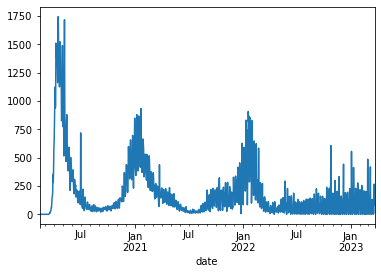

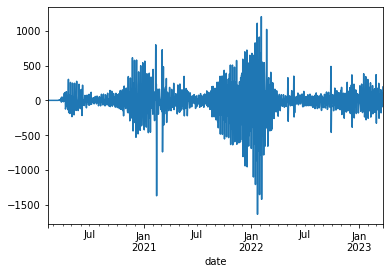

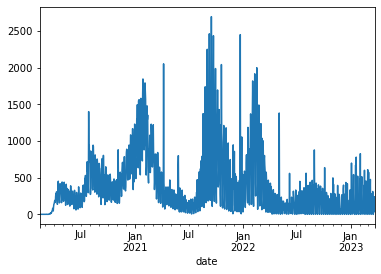

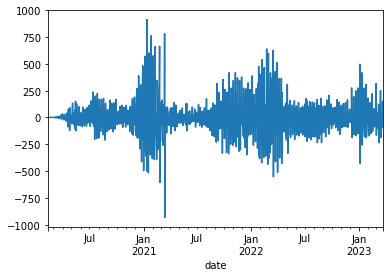

In [8]:
east['daily_deaths'].plot()
plt.show()

midwest['daily_deaths'].plot()
plt.show()

south['daily_deaths'].plot()
plt.show()

west['daily_deaths'].plot()
plt.show()

# splitting into train test
- setting a specific number for train test i.e. train is any data before 2023 and test is the last couple of months

In [18]:
easttrain = east[east.index < '2023-01-01']
easttest = east[east.index >= '2023-01-01']
print(easttrain.shape, easttest.shape)

midwesttrain = midwest[midwest.index < '2023-01-01']
midwesttest = midwest[midwest.index >= '2023-01-01']
print(midwesttrain.shape, midwesttest.shape)

southtrain = south[south.index < '2023-01-01']
southtest = south[south.index >= '2023-01-01']
print(southtrain.shape, southtest.shape)

westtrain = west[west.index < '2023-01-01']
westtest = west[west.index >= '2023-01-01']
print(westtrain.shape, westtest.shape)

(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)


# Visualizing data again

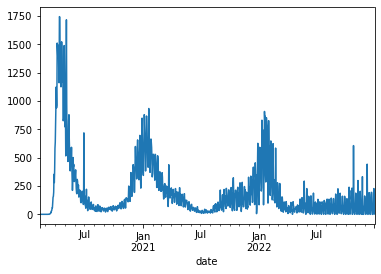

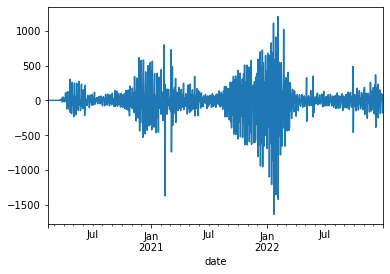

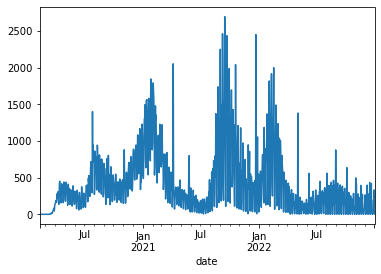

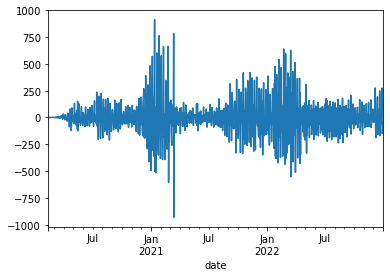

In [10]:
easttrain['daily_deaths'].plot()
plt.show()

midwesttrain['daily_deaths'].plot()
plt.show()

southtrain['daily_deaths'].plot()
plt.show()

westtrain['daily_deaths'].plot()
plt.show()

# Building auto_arima model

using these parameters: East and South best parameters with m = 12 
- yearly seasonality
- with m = 12: Best model:  ARIMA(4,1,2)(2,1,0)[12]

### defining a function for MASE

In [ ]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

### east

In [9]:
emodel = auto_arima(easttrain, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(emodel.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=12243.527, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=12875.145, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=12463.870, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=12247.750, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=12459.626, Time=0.32 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.56 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=12234.046, Time=0.91 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=2.75 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=12238.520, Time=0.62 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=12362.354, Time=0.70 sec
 ARIMA(2,1,1)(0,1,2)[7]             : AIC=12225.881, Time=1.22 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=12234.342, Time=0.69 sec
 ARIMA(2,1,1)(1,1,2)[7]             : AIC=inf, Time=3.18 sec
 ARIMA(2,1,1)(1,1,1)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(2,1,0)(0,1,2)[7]             : AIC=1

Training Set Metrics:
MAE: 48.15758962033707
MASE: 0.7358545103277312

Testing Set Metrics:
MAE: 57.652461518969844
MASE: 0.6034956556004856


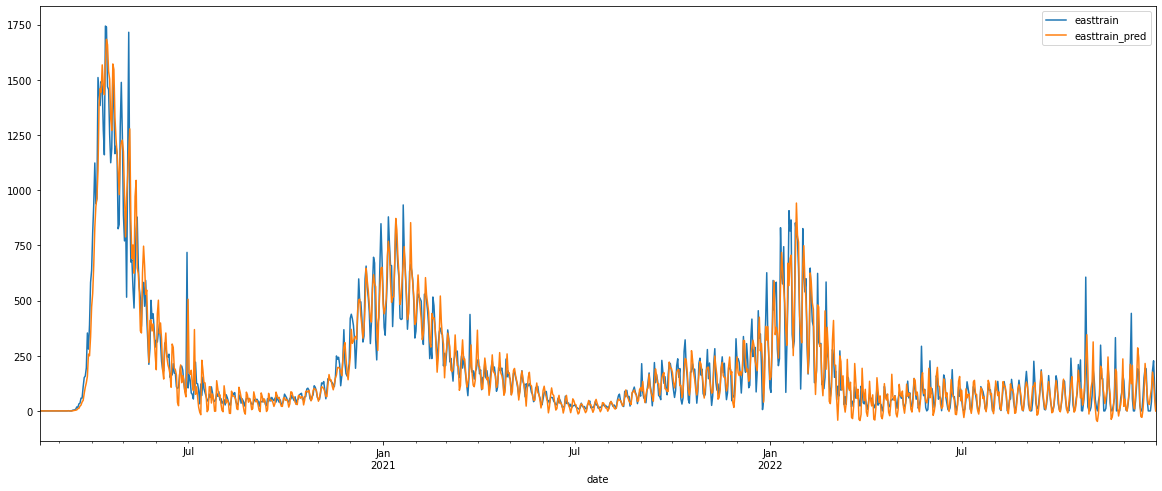

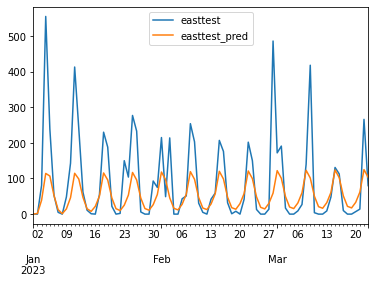

In [10]:
# plot train
easttrain_pred=emodel.fittedvalues()
#easttrain_pred = np.maximum(easttrain_pred, 0)
pd.concat([easttrain, easttrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['easttrain', 'easttrain_pred'])

# Calculate metrics for the training set
mae_train = mean_absolute_error(easttrain, easttrain_pred)
mase_train = MASE(easttrain, easttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# plot test
easttest_pred=emodel.predict(n_periods=len(easttest))
easttest_pred = np.maximum(easttest_pred, 0) * .5
pd.concat([easttest, easttest_pred], axis=1).plot()
plt.legend(['easttest', 'easttest_pred'])

# Calculate metrics for the testing set
mae_test = mean_absolute_error(easttest, easttest_pred)
mase_test = MASE(easttest, easttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [11]:
emodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1054
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -6074.944
Date:                             Mon, 11 Mar 2024   AIC                          12165.887
Time:                                     12:06:01   BIC                          12205.509
Sample:                                 02-12-2020   HQIC                         12180.913
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9230      0.040     23.146      0.000       0.845       1.001
ar.L2         -0.4290      0.025    -17.396      0.000      -0.477      -0.381
ar.L3         -0.1594      0.026     -6.066      0.000      -0.211      -0.108
ma.L1         -1.4580      0.039    -37.004      0.000      -1.535      -1.381
ma.L2          0.7669      0.031     24.744      0.000       0.706       0.828
ar.S.L7        0.2190      0.025      8.875      0.000       0.171       0.267
ma.S.L7       -0.8959      0.015    -59.126      0.000      -0.926      -0.866
sigma2      6513.8551    136.635     47.673      0.000    6246.055    6781.655
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):              3210.80
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
n_periods=12
forecast, conf_int = emodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01    -25.079843
2023-01-02      3.836468
2023-01-03     78.309263
2023-01-04    228.484395
2023-01-05    213.935362
2023-01-06    104.324567
2023-01-07     25.050558
2023-01-08      2.326708
2023-01-09     29.253769
2023-01-10     92.393018
2023-01-11    229.287851
2023-01-12    197.044906
Freq: D, dtype: float64
Confidence Interval: [[-183.26551347  133.10582719]
 [-170.61670563  178.28964233]
 [-102.86913766  259.48766296]
 [  43.52055455  413.44823587]
 [  22.19561877  405.6751053 ]
 [-100.39411576  309.04324882]
 [-197.57188546  247.67300211]
 [-261.66159304  266.31500811]
 [-255.76789035  314.27542781]
 [-206.21013382  390.99617019]
 [ -79.3626865   537.93838856]
 [-122.16532954  516.25514202]]


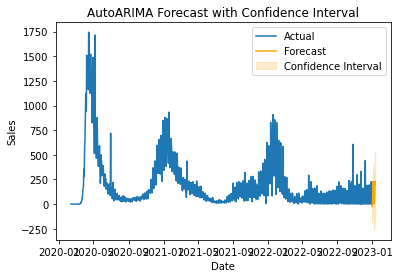

In [13]:
forecast_index = pd.date_range(easttrain.index[-1], periods=n_periods + 1, freq=easttrain.index.freq)[-n_periods:]

plt.plot(easttrain.index, easttrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Midwest
- auto arima selected Best model:  ARIMA(4,1,0)(2,1,0)[12]          

In [14]:
mmodel = auto_arima(midwesttrain, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(mmodel.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=14572.048, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=13838.863, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=14004.478, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=13789.303, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=13774.961, Time=1.16 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=13773.521, Time=0.49 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=13772.274, Time=0.36 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=13773.458, Time=0.49 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=14354.731, Time=0.22 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=13577.354, Time=0.37 sec
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=13814.129, Time=0.11 sec
 ARIMA(2,1,0)(1,1,1)[7]             :

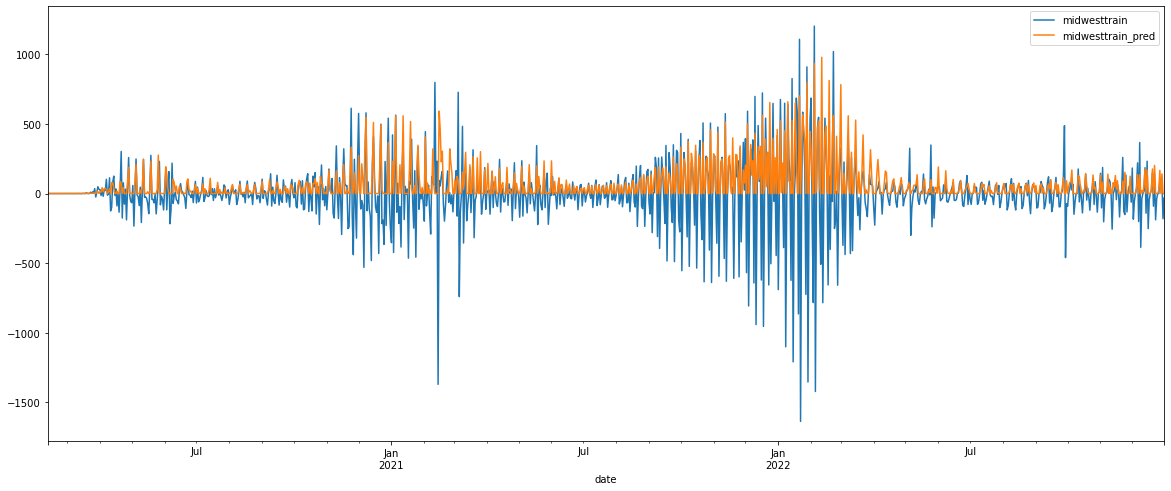

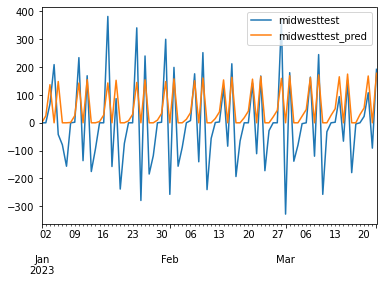

Training Set Metrics:
MAE: 109.95159212415453
MASE: 0.49337793505124183

Testing Set Metrics:
MAE: 31.270375857370965
MASE: 0.27253071276598323


In [33]:
midwesttrain_pred=mmodel.fittedvalues()

# clipping negatives - train
midwesttrain_pred = np.maximum(midwesttrain_pred, 0)
#midwesttrain = np.maximum(midwesttrain, 0)

pd.concat([midwesttrain, midwesttrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['midwesttrain', 'midwesttrain_pred'])
plt.show()

midwesttest_pred=mmodel.predict(n_periods=len(midwesttest))
# clipping negatives - test
midwesttest_pred = np.maximum(midwesttest_pred, 0)
midwesttest1 = np.maximum(midwesttest, 0)

pd.concat([midwesttest, midwesttest_pred], axis=1).plot()
plt.legend(['midwesttest', 'midwesttest_pred'])
plt.show()

# Calculate metrics for the training set
mae_train = mean_absolute_error(midwesttrain, midwesttrain_pred)
mase_train = MASE(midwesttrain, midwesttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(midwesttest1, midwesttest_pred)
mase_test = MASE(midwesttest1, midwesttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [21]:
mmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1054
Model:             SARIMAX(5, 1, 0)x(2, 1, [1], 7)   Log Likelihood               -6619.787
Date:                             Mon, 11 Mar 2024   AIC                          13257.574
Time:                                     12:12:59   BIC                          13302.148
Sample:                                 02-12-2020   HQIC                         13274.478
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2829      0.014    -90.394      0.000      -1.311      -1.255
ar.L2         -1.1867      0.025    -47.787      0.000      -1.235      -1.138
ar.L3         -1.0045      0.028    -36.486      0.000      -1.058      -0.951
ar.L4         -0.7137      0.027    -26.555      0.000      -0.766      -0.661
ar.L5         -0.3293      0.022    -14.811      0.000      -0.373      -0.286
ar.S.L7        0.1023      0.070      1.456      0.145      -0.035       0.240
ar.S.L14      -0.1112      0.033     -3.350      0.001      -0.176      -0.046
ma.S.L7       -0.4315      0.075     -5.781      0.000      -0.578      -0.285
sigma2      1.832e+04    360.322     50.839      0.000    1.76e+04     1.9e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):              5188.85
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
n_periods=12
forecast, conf_int = mmodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01     -9.658030
2023-01-02     25.229022
2023-01-03    136.873366
2023-01-04    -40.123738
2023-01-05    148.307448
2023-01-06   -199.546040
2023-01-07    -31.320225
2023-01-08      1.233578
2023-01-09     25.570566
2023-01-10    142.820248
2023-01-11    -42.980579
2023-01-12    155.026747
Freq: D, dtype: float64
Confidence Interval: [[-274.92963486  255.61357401]
 [-250.45131157  300.90935545]
 [-142.74216275  416.48889496]
 [-321.12619335  240.8787164 ]
 [-139.04811618  435.66301283]
 [-496.36000725   97.26792664]
 [-334.5294995   271.88905016]
 [-351.31130311  353.77845878]
 [-327.18568182  378.32681416]
 [-218.68077905  504.32127569]
 [-412.79238414  326.83122566]
 [-225.19778748  535.25128196]]


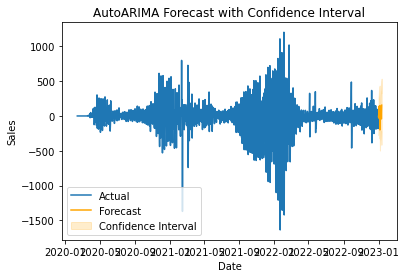

In [23]:
forecast_index = pd.date_range(midwesttrain.index[-1], periods=n_periods + 1, freq=midwesttrain.index.freq)[-n_periods:]

plt.plot(midwesttrain.index, midwesttrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### South

In [24]:
smodel = auto_arima(southtrain, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(smodel.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=14039.838, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=14880.707, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=14379.124, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=14039.739, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=14275.324, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=14038.243, Time=1.10 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=14108.128, Time=0.27 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.89 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=14039.328, Time=0.55 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=14068.086, Time=0.56 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=14532.143, Time=0.34 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=14037.951, Time=1.49 sec
 ARIMA(1,1,1)(1,1,0)[7]             :

Training Set Metrics:
MAE: 110.53665027608841
MASE: 0.5453855473330324

Testing Set Metrics:
MAE: 100.21754410663826
MASE: 0.46402315494670743


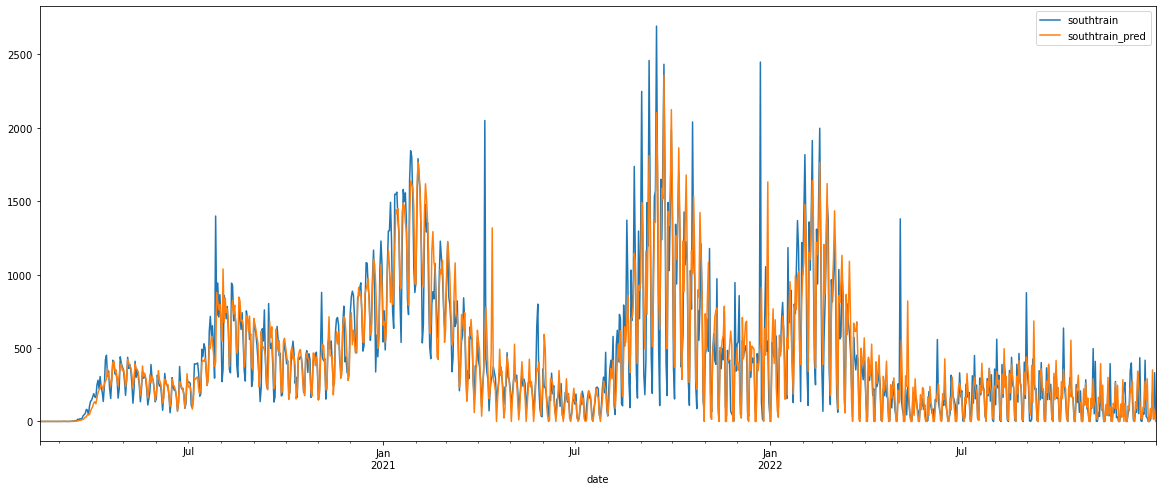

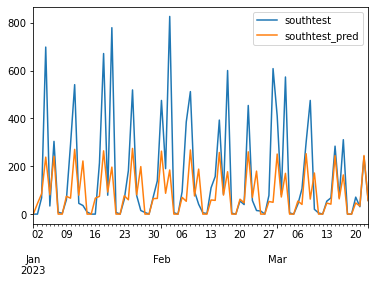

In [25]:
# plot train
southtrain_pred=smodel.fittedvalues()
southtrain_pred = np.maximum(southtrain_pred, 0)
pd.concat([southtrain, southtrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['southtrain', 'southtrain_pred'])

# Calculate metrics for the training set
mae_train = mean_absolute_error(southtrain, southtrain_pred)
mase_train = MASE(southtrain, southtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# plot test
southtest_pred=smodel.predict(n_periods=len(southtest))
southtest_pred = np.maximum(southtest_pred, 0)
pd.concat([southtest, southtest_pred], axis=1).plot()
plt.legend(['southtest', 'southtest_pred'])

# Calculate metrics for the testing set
mae_test = mean_absolute_error(southtest, southtest_pred)
mase_test = MASE(southtest, southtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [27]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1054
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -7009.452
Date:                             Mon, 11 Mar 2024   AIC                          14032.904
Time:                                     12:16:06   BIC                          14067.573
Sample:                                 02-12-2020   HQIC                         14046.051
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8746      0.031    -28.155      0.000      -0.935      -0.814
ar.L2          0.1074      0.025      4.216      0.000       0.057       0.157
ma.L1          0.1057      0.026      4.067      0.000       0.055       0.157
ma.L2         -0.8367      0.022    -37.429      0.000      -0.881      -0.793
ar.S.L7        0.3862      0.021     18.074      0.000       0.344       0.428
ma.S.L7       -0.8843      0.015    -60.222      0.000      -0.913      -0.856
sigma2      3.842e+04    656.396     58.533      0.000    3.71e+04    3.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):             12665.30
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                             1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
n_periods=12
forecast, conf_int = smodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01     -4.468359
2023-01-02     44.180506
2023-01-03     84.737194
2023-01-04    238.058723
2023-01-05     80.646777
2023-01-06    241.375448
2023-01-07     -2.167185
2023-01-08    -30.617263
2023-01-09     74.367295
2023-01-10     66.650831
2023-01-11    270.584605
2023-01-12     78.995759
Freq: D, dtype: float64
Confidence Interval: [[-388.64600722  379.70928918]
 [-350.11895108  438.47996209]
 [-315.20702184  484.68140984]
 [-165.55415798  641.67160402]
 [-327.85746557  489.15102028]
 [-170.68637386  653.43726958]
 [-418.99253216  414.65816161]
 [-515.11029775  453.87577164]
 [-421.85277626  570.58736663]
 [-437.29567491  570.5973361 ]
 [-241.30149045  782.47070088]
 [-440.07568013  598.06719759]]


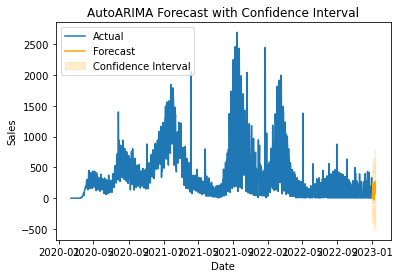

In [29]:
forecast_index = pd.date_range(southtrain.index[-1], periods=n_periods + 1, freq=southtrain.index.freq)[-n_periods:]

plt.plot(southtrain.index, southtrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### west

In [30]:
wmodel = auto_arima(westtrain, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(wmodel.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=14267.036, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=13454.234, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=13709.459, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=13409.099, Time=0.48 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=13364.864, Time=0.50 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=13362.864, Time=0.48 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=13364.864, Time=0.61 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=13926.705, Time=0.32 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=13120.257, Time=0.33 sec
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=13449.558, Time=0.09 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=1

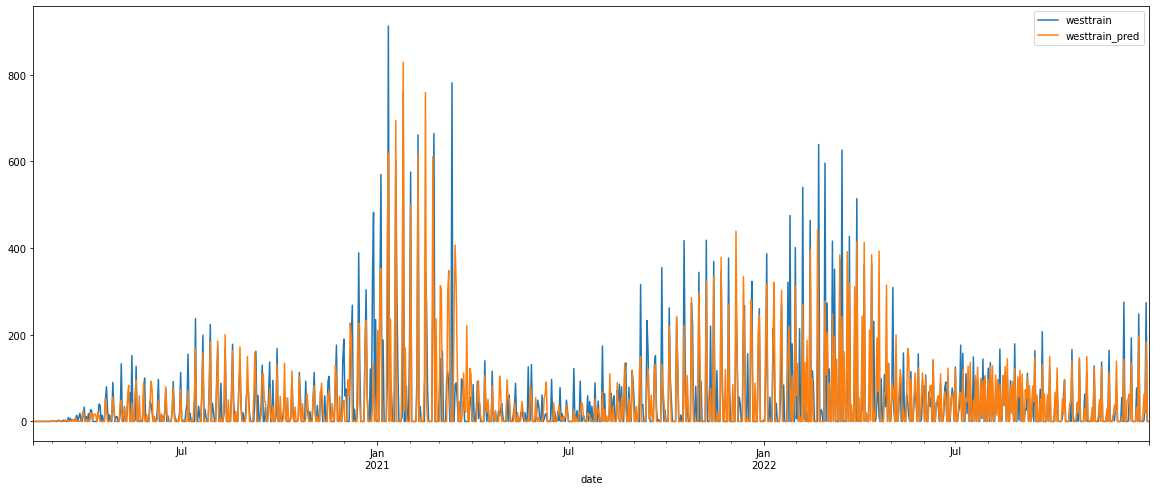

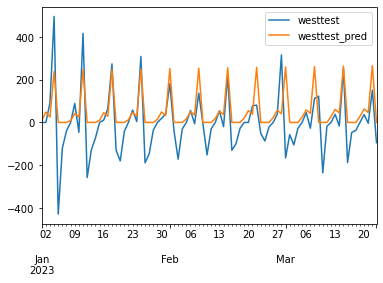

Training Set Metrics:
MAE: 32.79919435248332
MASE: 0.4167879667555443

Testing Set Metrics:
MAE: 33.90252226408757
MASE: 0.4119568411927833


In [31]:
westtrain_pred=wmodel.fittedvalues()

# Clipping negatives - train
westtrain_pred = np.maximum(westtrain_pred, 0)
westtrain = np.maximum(westtrain, 0)

pd.concat([westtrain, westtrain_pred], axis=1).plot(figsize=(20,8))
plt.legend(['westtrain', 'westtrain_pred'])
plt.show()

westtest_pred=wmodel.predict(n_periods=len(westtest))

# Clipping negatives - test
westtest_pred = np.maximum(westtest_pred, 0)
westtest1 = np.maximum(westtest, 0)

pd.concat([westtest, westtest_pred], axis=1).plot()
plt.legend(['westtest', 'westtest_pred'])
plt.show()

# Calculate metrics for the training set
mae_train = mean_absolute_error(westtrain, westtrain_pred)
mase_train = MASE(westtrain, westtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate metrics for the testing set
mae_test = mean_absolute_error(westtest1, westtest_pred)
mase_test = MASE(westtest1, westtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [20]:
wmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1054
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6996.618
Date:                            Mon, 26 Feb 2024   AIC                          14007.235
Time:                                    19:15:06   BIC                          14041.871
Sample:                                02-12-2020   HQIC                         14020.373
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2235      0.023    -53.679      0.000      -1.268      -1.179
ar.L2         -1.1907      0.034    -35.398      0.000      -1.257      -1.125
ar.L3         -0.7321      0.034    -21.845      0.000      -0.798      -0.666
ar.L4         -0.2031      0.026     -7.700      0.000      -0.255      -0.151
ar.S.L12      -0.5513      0.018    -31.360      0.000      -0.586      -0.517
ar.S.L24      -0.7588      0.013    -57.267      0.000      -0.785      -0.733
sigma2      3.952e+04   1151.543     34.319      0.000    3.73e+04    4.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               357.36
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.10
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
n_periods=12
forecast, conf_int = wmodel.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2023-01-01     24.395996
2023-01-02     55.376287
2023-01-03   -108.370101
2023-01-04     11.883587
2023-01-05     -2.845535
2023-01-06    -94.711279
2023-01-07    -80.310145
2023-01-08     17.074515
2023-01-09    101.763645
2023-01-10    -51.878384
2023-01-11    -79.566023
2023-01-12    154.319343
Freq: D, dtype: float64
Confidence Interval: [[-365.23777207  414.02976363]
 [-343.86975445  454.62232903]
 [-508.9154875   292.17528584]
 [-422.70562297  446.47279732]
 [-456.33904441  450.64797415]
 [-548.86168677  359.43912938]
 [-540.69059828  380.07030744]
 [-463.86081363  498.0098435 ]
 [-386.69115253  590.21844233]
 [-543.92285268  440.16608427]
 [-581.31775256  422.18570724]
 [-358.93762284  667.57630922]]


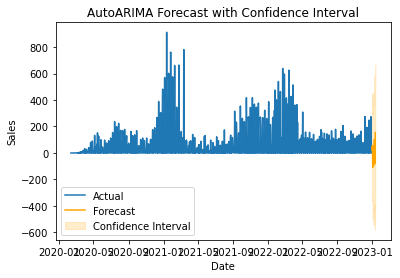

In [22]:
forecast_index = pd.date_range(westtrain.index[-1], periods=n_periods + 1, freq=westtrain.index.freq)[-n_periods:]

plt.plot(westtrain.index, westtrain['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()